In [92]:
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import ssl
import random
import os
import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

from keras.utils import plot_model
from sklearn.metrics import classification_report
from collections import Counter
import tensorflow as tf

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16

import scipy

from keras import Model, layers
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D
# module = hub.Module("https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1")

ModuleNotFoundError: No module named 'sklearn'

In [73]:
train_datagen = ImageDataGenerator( rescale = 1.0/255,shear_range=0.2,zoom_range=0.2)
# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance. 
train_generator = train_datagen.flow_from_directory("train",
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(128, 128))


validation_datagen = ImageDataGenerator(rescale = 1.0/255) #we are only normalising to make the prediction, the other parameters were used for agumentation and train weights
validation_generator = validation_datagen.flow_from_directory("train", shuffle=True, batch_size=32, class_mode='categorical', target_size=(128, 128))

Found 49728 images belonging to 24 classes.
Found 49728 images belonging to 24 classes.


In [74]:
inv_map_classes = {v: k for k, v in validation_generator.class_indices.items()}
print(validation_generator.class_indices)
print(inv_map_classes)

{'0123': 0, '0132': 1, '0213': 2, '0231': 3, '0312': 4, '0321': 5, '1023': 6, '1032': 7, '1203': 8, '1230': 9, '1302': 10, '1320': 11, '2013': 12, '2031': 13, '2103': 14, '2130': 15, '2301': 16, '2310': 17, '3012': 18, '3021': 19, '3102': 20, '3120': 21, '3201': 22, '3210': 23}
{0: '0123', 1: '0132', 2: '0213', 3: '0231', 4: '0312', 5: '0321', 6: '1023', 7: '1032', 8: '1203', 9: '1230', 10: '1302', 11: '1320', 12: '2013', 13: '2031', 14: '2103', 15: '2130', 16: '2301', 17: '2310', 18: '3012', 19: '3021', 20: '3102', 21: '3120', 22: '3201', 23: '3210'}


In [75]:
def show_few_images(number_of_examples=2, predict_using_model=None):
    seg_train_folders = "train"
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(seg_train_folders)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(seg_train_folders)):
        if(folder != ".DS_Store"):
            image_ids = os.listdir(os.path.join(seg_train_folders,folder))
            for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
                
                display = plt.imread(os.path.join(seg_train_folders,folder,image_ids[j]))
                plt.axis('off')
                ax1[axs].imshow(display)
                title = 'True:'+folder
                if(predict_using_model):
                    predicted_classname = inv_map_classes[np.argmax(inception_best_model.predict(np.array([display])))]
                    title = title+'\nPredict :'+predicted_classname
                ax1[axs].set_title(title)
                axs=axs+1

In [76]:
def save_history(history, model_name):
    #convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 

    # save to json:  
    hist_json_file = model_name+'_history.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv: 
    hist_csv_file = model_name+'_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
def plot_accuracy_from_history(history, isinception=False):
    color = sns.color_palette()
    if(isinception == False):
        acc = history.history['acc']
        val_acc = history.history['val_acc']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
    

    epochs = range(len(acc))

    sns.lineplot(epochs, acc, label='Training Accuracy')
    sns.lineplot(epochs, val_acc,label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()
    
def plot_loss_from_history(history):
    color = sns.color_palette()
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    sns.lineplot(epochs, loss,label='Training Loss')
    sns.lineplot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()
    
def do_history_stuff(history, history_file_name, isinception=False):
    save_history(history, history_file_name)
    plot_accuracy_from_history(history, isinception)
    plot_loss_from_history(history)

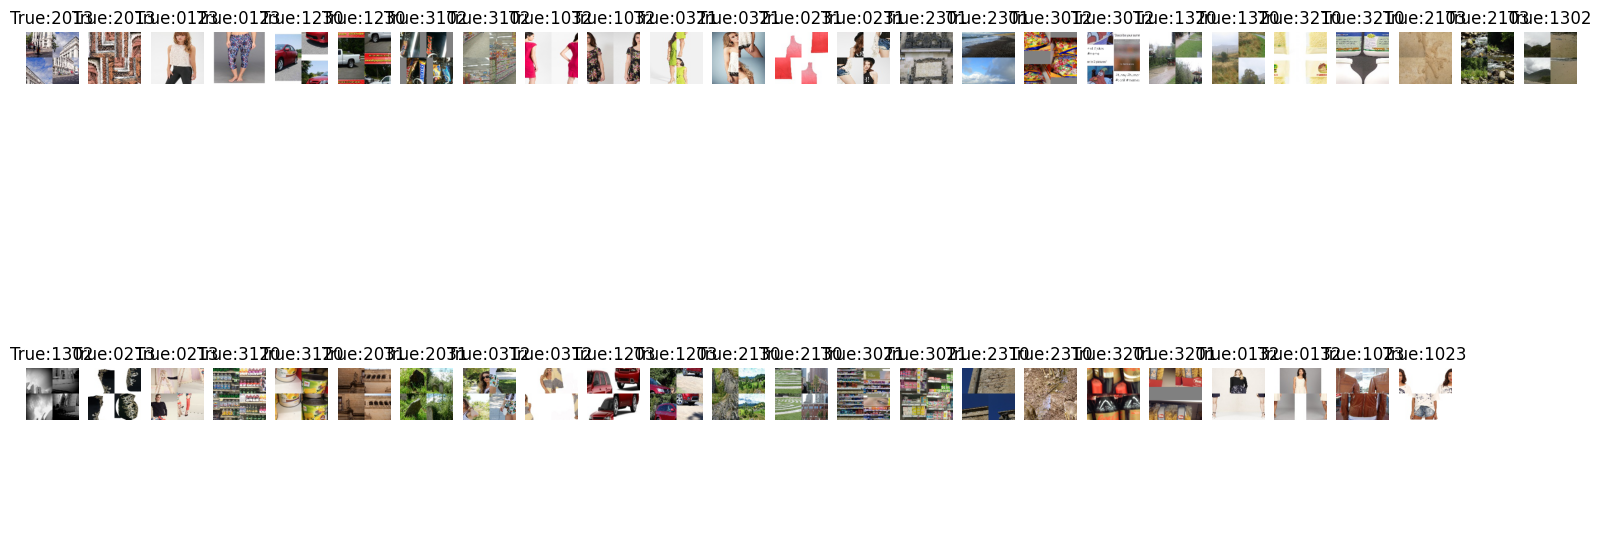

In [77]:
show_few_images(2)

In [94]:
ssl._create_default_https_context = ssl._create_unverified_context
inception_epoch = 60
InceptionV3_model = InceptionV3(input_shape=(150,150,3),weights='imagenet', include_top=False)
for layer in InceptionV3_model.layers[:249]:
   layer.trainable = False
for layer in InceptionV3_model.layers[249:]:
   layer.trainable = True
InceptionV3_last_output = InceptionV3_model.output
InceptionV3_maxpooled_output = Flatten()(InceptionV3_last_output)
InceptionV3_x = Dense(1024, activation='relu')(InceptionV3_maxpooled_output)
InceptionV3_x = Dropout(0.5)(InceptionV3_x)
InceptionV3_x = Dense(6, activation='softmax')(InceptionV3_x)
InceptionV3_x_final_model = Model(inputs=InceptionV3_model.input,outputs=InceptionV3_x)
InceptionV3_x_final_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=['accuracy'])

# number_of_epochs = inception_epoch
inception_filepath = 'inceptionv3_'+'-saved-model-{epoch:02d}-loss-{loss:.2f}.hdf5'
inception_checkpoint = tf.keras.callbacks.ModelCheckpoint(inception_filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
inception_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
inceptionv3_history = InceptionV3_x_final_model.fit(train_generator, epochs = 60, validation_data = validation_generator,callbacks=[inception_checkpoint,inception_early_stopping])

# do_history_stuff(inceptionv3_history, 'inceptionv3_model', True)  

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


NameError: name 'scipy' is not defined